# Compute FSS

In [1]:
from __future__ import division        
from compute_FSS import fss_prob, fss_det
from fss90 import mod_fss
import compare_fss_flavors as cff
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
# Open datasets for MCS:
#observations and reanalysis
ds_prIMERG = xr.open_dataset('/media/irene/Elements/Laptop_dec2023/Thesis_data/obs/gpm_PP_mcs20080714-20080724.nc') #imerg
ds_ERA = xr.open_dataset('/media/irene/Elements/Laptop_dec2023/Thesis_data/obs/ERA5-pr-acpr-t2m-olr-MCScase.nc') #with range lat:25-42, lon:70-114 and days 2008-July 14 to 24
ds_GLDAS = xr.open_dataset('/media/irene/Elements/Laptop_dec2023/Thesis_data/obs/GLDAS.nc') #it's not hourly, it's every 3 hours
ds_APHRO = xr.open_dataset('/media/irene/Elements/Laptop_dec2023/Thesis_data/obs/APHRO_MA_025deg_V1801R1.2008.nc')
ds_MSWEP = xr.open_dataset('/media/irene/Elements/Laptop_dec2023/Thesis_data/obs/P-MSWEP-MCS.nc') #it's every 3 hours + whole world

#WRF simulations: REGRID
ds_prtho = xr.open_dataset('/media/irene/Elements/wrf_micro/Thompson/reg_wrftho_PTO-16to24.nc')
ds_prmor = xr.open_dataset('/media/irene/Elements/wrf_micro/Morrison/reg_wrfmor_PTO-16to24.nc')
ds_prcam = xr.open_dataset('/media/irene/Elements/wrf_micro/CAM/reg_wrfcam_PTO-16to24.nc')
ds_prylin = xr.open_dataset('/media/irene/Elements/wrf_micro/Ylin/reg_wrfylin_PTO-16to24.nc')
ds_prwdm7 = xr.open_dataset('/media/irene/Elements/wrf_micro/WDM7/reg_wrfwdm7_PTO-16to24.nc')
ds_prwdm6 = xr.open_dataset('/media/irene/Elements/wrf_micro/WDM6/reg_wrfwdm6_PTO-16to24.nc')

In [3]:
# Cut right time range (WRF time range is already 16 to 24 July)
ds_ERA = ds_ERA.sel(time=slice('2008-07-16T00:00:00.000000000', '2008-07-24T23:00:00.000000000'))
ds_GLDAS = ds_GLDAS.sel(time=slice('2008-07-16T00:00:00.000000000', '2008-07-24T23:00:00.000000000'))
ds_APHRO = ds_APHRO.sel(time=slice('2008-07-16T00:00:00.000000000', '2008-07-25T00:00:00.000000000'))
ds_MSWEP = ds_MSWEP.sel(time=slice('2008-07-16T00:00:00.000000000', '2008-07-24T23:00:00.000000000'))

# Define the spatial domain for whole Tibetan Plateau 25-40N, 70-114E (WRF already has the right one)
ds_prERA = ds_ERA.sel(latitude=slice(40,25))
ds_prGLDAS = ds_GLDAS.sel(lat=slice(25,40), lon=slice(70,115))
ds_prAPHRO = ds_APHRO.sel(lat=slice(25,40), lon=slice(70,115))
ds_prMSWEP = ds_MSWEP.sel(lat=slice(40,25), lon=slice(70,115))


In [4]:
# Define region of interest: Sichuan basin
lat1, lat2 = 26, 35
lon1, lon2 = 100, 114

# Cut spatial domain
ds_prthoc = ds_prtho.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2))
ds_prmorc = ds_prmor.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2))
ds_prcamc = ds_prcam.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2))
ds_prylinc = ds_prylin.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2))
ds_prwdm7c = ds_prwdm7.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2))
ds_prwdm6c = ds_prwdm6.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2))

ds_prERAc = ds_ERA.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2))
ds_prGLDASc = ds_GLDAS.sel(lat=slice(lat1,lat2+0.2), lon=slice(lon1,lon2+0.2)) #+-0.2 because of spatial resolution of dataset
ds_prAPHROc = ds_APHRO.sel(lat=slice(lat1,lat2+0.2), lon=slice(lon1,lon2+0.2))
ds_prMSWEPc = ds_MSWEP.sel(lat=slice(lat2+0.2,lat1-0.2), lon=slice(lon1-0.2,lon2+0.2))  #+-0.2 because of spatial resolution of dataset

#
lati, longi = ds_prERAc.latitude.values.flatten(), ds_prERAc.longitude.values.flatten()
ds_prGLDASc =  ds_prGLDASc.sel(lat=lati, lon=longi, method="nearest")
ds_prAPHROc =  ds_prAPHROc.sel(lat=lati, lon=longi, method="nearest")
ds_prMSWEPc =  ds_prMSWEPc.sel(lat=lati, lon=longi, method="nearest")

In [5]:
# Mean precipitation rate over time
meant_prthoc = (ds_prthoc.PREC_ACC_NC*24).mean(dim='XTIME') #*24 to have values in mm/day
meant_prmorc = (ds_prmorc.PREC_ACC_NC*24).mean(dim='XTIME')
meant_prcamc = (ds_prcamc.PREC_ACC_NC*24).mean(dim='XTIME')
meant_prylinc = (ds_prylinc.PREC_ACC_NC*24).mean(dim='XTIME')
meant_prwdm7c = (ds_prwdm7c.PREC_ACC_NC*24).mean(dim='XTIME')
meant_prwdm6c = (ds_prwdm6c.PREC_ACC_NC*24).mean(dim='XTIME')
meant_prERAc = (ds_prERAc.mtpr*86400).mean(dim='time') #*86400 to have mm/day
meant_prGLDASc = (ds_prGLDASc.Rainf_f_tavg*86400).mean(dim=('time'))
meant_prAPHROc = (ds_prAPHROc.precip).mean(dim=('time'))
meant_prMSWEPc = (ds_prMSWEPc.precipitation*8).mean(dim=('time'))

#IMERG data
lati, longi = ds_prERAc.latitude.values.flatten(), ds_prERAc.longitude.values.flatten()
ds_prIMERG['lat'], ds_prIMERG['lon'] = ds_prIMERG.latitude.values, ds_prIMERG.longitude.values
ds_prIMERGc = ds_prIMERG.sel(lat=slice(26,35), lon=slice(100,114)) #select Sichuan Basin: why 25???

# Compute average precipitation rate
meant_prIMERGc = (ds_prIMERGc['var'][0][2:11]).mean(dim=('days', 'hours'))*24
meant_prIMERGc = meant_prIMERGc.sel(lat=lati, lon=longi, method="nearest") #select the nearest points to ERA5 ones
meant_prIMERGc = meant_prIMERGc.transpose(transpose_coords=True, missing_dims='raise') # to have lat, lon

In [6]:
# To compute FSSrandom and FSSuniform ###########CAREFUL WITH THIS AND PLOTS - NEEDS TO BE CHANGED EVERY TIME
# Define the thresholds
thresholds_mcs = [5, 10, 15]

# Calculate the total number of points in the dataset
total_points_mcs = meant_prIMERGc.size 
# Initialise arrays
num_exceeding_mcs = np.zeros(len(thresholds_mcs))
FSSr_mcs = np.zeros(len(thresholds_mcs))
FSSu_mcs = np.zeros(len(thresholds_mcs))

# Loop over each threshold and calculate the number of grid exceeding the set threshold
for i in range(0, len(thresholds_mcs)):
  num_exceeding_mcs[i] = np.sum(meant_prIMERGc > thresholds_mcs[i])

  # Compute the fraction of values exceeding the threshold
  FSSr_mcs[i] = num_exceeding_mcs[i] / total_points_mcs

  FSSu_mcs[i] = 0.5 + (FSSr_mcs[i]/2)

In [7]:
# Open datasets for SNOW:
#observations and reanalysis
dss_prIMERG = xr.open_dataset('/media/irene/Elements/Laptop_dec2023/Thesis_data/sobs/gpm_PP_snow20181001-20181010.nc')
dss_ERA = xr.open_dataset('/media/irene/Elements/Laptop_dec2023/Thesis_data/sobs/ERA5-pr-t2m-olr-SNOWcase.nc') 
dss_GLDAS = xr.open_dataset('/media/irene/Elements/Laptop_dec2023/Thesis_data/sobs/GLDAS.nc') #it's not hourly, it's every 3 hours
dss_MSWEP = xr.open_dataset('/media/irene/Elements/Laptop_dec2023/Thesis_data/sobs/P-MSWEP-Snow.nc') #it's every 3 hours + whole world

#WRF simulations REGRIDDED
dss_prtho = xr.open_dataset('/media/irene/Elements/wrf_micro_snow/Thompson/reg_wrftho_PTO-4to9.nc')
dss_prmor = xr.open_dataset('/media/irene/Elements/wrf_micro_snow/Morrison/reg_wrfmor_PTO-4to9.nc')
dss_prcam = xr.open_dataset('/media/irene/Elements/wrf_micro_snow/CAM/reg_wrfcam_PTO-4to9.nc')
dss_prylin = xr.open_dataset('/media/irene/Elements/wrf_micro_snow/Ylin/reg_wrfylin_PTO-4to9.nc')
dss_prwdm7 = xr.open_dataset('/media/irene/Elements/wrf_micro_snow/WDM7/reg_wrfwdm7_PTO-4to9.nc')
dss_prwdm6 = xr.open_dataset('/media/irene/Elements/wrf_micro_snow/WDM6/reg_wrfwdm6_PTO-4to9.nc')

In [8]:
# Cut time range (wrf time range is already 4 to 9 Oct)
dss_ERA = dss_ERA.sel(time=slice('2018-10-04T00:00:00.000000000', '2018-10-09T23:00:00.000000000'))
dss_GLDAS = dss_GLDAS.sel(time=slice('2018-10-04T00:00:00.000000000', '2018-10-09T23:00:00.000000000'))
dss_MSWEP = dss_MSWEP.sel(time=slice('2018-10-04T00:00:00.000000000', '2018-10-09T23:00:00.000000000'))

# Cut spatial domain
dss_prERA = dss_ERA.sel(latitude=slice(40,25))
dss_prGLDAS = dss_GLDAS.sel(lat=slice(40,25), lon=slice(70,115))
dss_prMSWEP = dss_MSWEP.sel(lat=slice(40,25), lon=slice(70,115))

In [9]:
# Define region of interest: Nam Co
lat1, lat2 = 27, 35
lon1, lon2 = 90, 105

# Cut spatial domain
dss_prthoc = dss_prtho.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2))
dss_prmorc = dss_prmor.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2))
dss_prcamc = dss_prcam.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2))
dss_prylinc = dss_prylin.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2))
dss_prwdm7c = dss_prwdm7.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2))
dss_prwdm6c = dss_prwdm6.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2))
dss_prERAc = dss_ERA.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2))
dss_prGLDASc = ds_GLDAS.sel(lat=slice(lat1,lat2+0.2), lon=slice(lon1,lon2+0.2))
dss_prMSWEPc = ds_prMSWEP.sel(lat=slice(lat2+0.2,lat1-0.2), lon=slice(lon1-0.2,lon2+0.2)) #+-0.2 because of spatial resolution of dataset

#
slati, slongi = dss_prERAc.latitude.values.flatten(), dss_prERAc.longitude.values.flatten()
dss_prGLDASc =  dss_prGLDASc.sel(lat=slati, lon=slongi, method="nearest")
dss_prMSWEPc =  dss_prMSWEPc.sel(lat=slati, lon=slongi, method="nearest")

In [10]:
# Mean precipitation rate over time
smeant_prthoc = (dss_prthoc.PREC_ACC_NC*24).mean(dim='XTIME') #*24 to have values in mm/day
smeant_prmorc = (dss_prmorc.PREC_ACC_NC*24).mean(dim='XTIME')
smeant_prcamc = (dss_prcamc.PREC_ACC_NC*24).mean(dim='XTIME')
smeant_prylinc = (dss_prylinc.PREC_ACC_NC*24).mean(dim='XTIME')
smeant_prwdm7c = (dss_prwdm7c.PREC_ACC_NC*24).mean(dim='XTIME')
smeant_prwdm6c = (dss_prwdm6c.PREC_ACC_NC*24).mean(dim='XTIME')
smeant_prERAc = (dss_prERAc.mtpr*86400).mean(dim='time') #*86400 to have mm/day
smeant_prGLDASc = (dss_prGLDASc.Rainf_f_tavg*86400).mean(dim=('time'))
smeant_prMSWEPc = (dss_prMSWEPc.precipitation*8).mean(dim=('time'))

# IMERG data
latii, longii = dss_prERAc.latitude.values.flatten(), dss_prERAc.longitude.values.flatten()
dss_prIMERG['lat'], dss_prIMERG['lon'] = dss_prIMERG.latitude.values, dss_prIMERG.longitude.values
dss_prIMERGc = dss_prIMERG.sel(lat=slice(27,35), lon=slice(90,105)) #select Sichuan Basin: or 26??

# Compute average precipitation rate
smeant_prIMERGc = (dss_prIMERGc['var'][0][3:9]).mean(dim=('days', 'hours'))*24
smeant_prIMERGc = smeant_prIMERGc.sel(lat=latii, lon=longii, method="nearest") #select the nearest points to ERA5 ones
smeant_prIMERGc = smeant_prIMERGc.transpose(transpose_coords=True, missing_dims='raise') # to have lat, lon

In [11]:
# To compute FSSrandom and FSSuniform ###########CAREFUL WITH THIS AND PLOTS - NEEDS TO BE CHANGED EVERY TIME
# Define the threshold
thresholds_snow = [2, 4, 6]

# Calculate the total number of points in the dataset
total_points_snow = smeant_prIMERGc.size 
# Initialise arrays
num_exceeding_snow = np.zeros(len(thresholds_snow))
FSSr_snow = np.zeros(len(thresholds_snow))
FSSu_snow = np.zeros(len(thresholds_snow))

# Loop over each threshold and calculate the fraction exceeding it
for i in range(0, len(thresholds_snow)):
  num_exceeding_snow[i] = np.sum(smeant_prIMERGc > thresholds_snow[i])

  # Compute the fraction of values exceeding the threshold
  FSSr_snow[i] = num_exceeding_snow[i] / total_points_snow

  FSSu_snow[i] = 0.5 + (FSSr_snow[i]/2)

In [12]:
# Compute FSS for different neighbourhoods sizes
thrsh1 = [15]
kernel1 = np.arange(1,16,1) # to have the grid size of the neighbourhood

ERA_fssg_mcs = fss_det(meant_prERAc.values, meant_prIMERGc.values, thrsh1, kernel1)
tho_fssg_mcs = fss_det(meant_prthoc.values, meant_prIMERGc.values, thrsh1, kernel1)
mor_fssg_mcs = fss_det(meant_prmorc.values, meant_prIMERGc.values, thrsh1, kernel1)
cam_fssg_mcs = fss_det(meant_prcamc.values, meant_prIMERGc.values, thrsh1, kernel1)
ylin_fssg_mcs = fss_det(meant_prylinc.values, meant_prIMERGc.values, thrsh1, kernel1)
wdm7_fssg_mcs = fss_det(meant_prwdm7c.values, meant_prIMERGc.values, thrsh1, kernel1)
wdm6_fssg_mcs = fss_det(meant_prwdm6c.values, meant_prIMERGc.values, thrsh1, kernel1)

Text(0.5, 0, 'Size of neighbourhood (event threshold=20mm/day)')

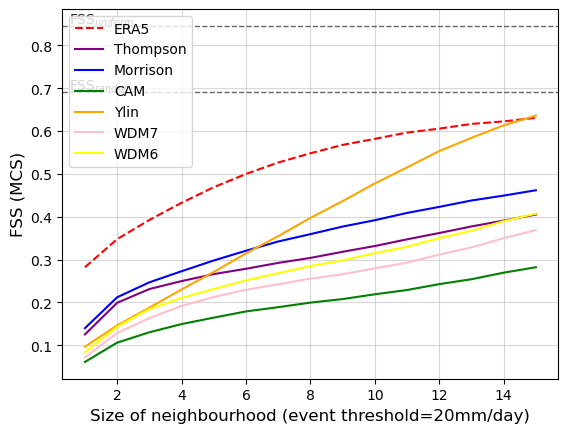

In [13]:
plt.plot(kernel1, ERA_fssg_mcs.flatten(), color='r', linestyle='dashed', label='ERA5')
plt.plot(kernel1, tho_fssg_mcs.flatten(), color='purple', label='Thompson')
plt.plot(kernel1, mor_fssg_mcs.flatten(), color='blue', label='Morrison')
plt.plot(kernel1, cam_fssg_mcs.flatten(), color='green', label='CAM')
plt.plot(kernel1, ylin_fssg_mcs.flatten(), color='orange', label='Ylin')
plt.plot(kernel1, wdm7_fssg_mcs.flatten(), color='pink', label='WDM7')
plt.plot(kernel1, wdm6_fssg_mcs.flatten(), color='yellow', label='WDM6')
# Add thresholds
plt.axhline(y=FSSr_mcs[0], color='k', linestyle='dashed', linewidth=1, alpha=0.6)
plt.axhline(y=FSSu_mcs[0], color='k', linestyle='dashed', linewidth=1, alpha=0.6)
plt.text(0.5, FSSr_mcs[0]+0.005, r'FSS$_{random}$', color='k', alpha=0.85, fontsize=10)
plt.text(0.5, FSSu_mcs[0]+0.005, r'FSS$_{uniform}$', color='k', alpha=0.85, fontsize=10)

plt.legend()
plt.grid(alpha=0.5)
plt.ylabel('FSS (MCS)', fontsize=12)
plt.xlabel('Size of neighbourhood (event threshold=20mm/day)', fontsize=12)

In [14]:
# Compute FSS for different neighbourhoods sizes
thrsh2 = [7]
kernel2 = np.arange(1,16,1) # to have the grid size of the neighbourhood
ERA_fssg_snow = fss_det(smeant_prERAc.values, smeant_prIMERGc.values, thrsh2, kernel2)
tho_fssg_snow = fss_det(smeant_prthoc.values, smeant_prIMERGc.values, thrsh2, kernel2)
mor_fssg_snow = fss_det(smeant_prmorc.values, smeant_prIMERGc.values, thrsh2, kernel2)
cam_fssg_snow = fss_det(smeant_prcamc.values, smeant_prIMERGc.values, thrsh2, kernel2)
ylin_fssg_snow = fss_det(smeant_prylinc.values, smeant_prIMERGc.values, thrsh2, kernel2)
wdm7_fssg_snow = fss_det(smeant_prwdm7c.values, smeant_prIMERGc.values, thrsh2, kernel2)
wdm6_fssg_snow = fss_det(smeant_prwdm6c.values, smeant_prIMERGc.values, thrsh2, kernel2)

Text(0.5, 0, 'Size of neighbourhood (event threshold = 10 mm/day)')

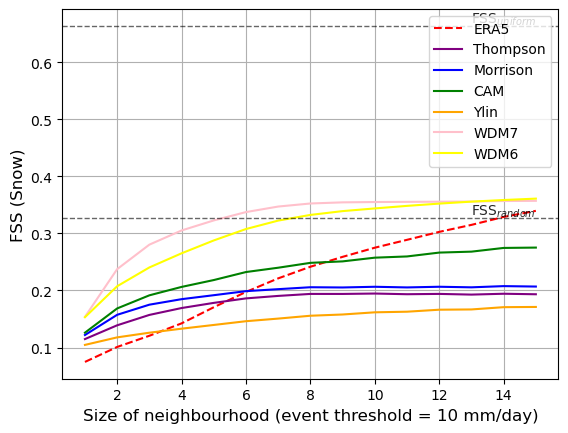

In [15]:
plt.plot(kernel2, ERA_fssg_snow.flatten(), color='r', linestyle='dashed', label='ERA5')
plt.plot(kernel2, tho_fssg_snow.flatten(), color='purple', label='Thompson')
plt.plot(kernel2, mor_fssg_snow.flatten(), color='blue', label='Morrison')
plt.plot(kernel2, cam_fssg_snow.flatten(), color='green', label='CAM')
plt.plot(kernel2, ylin_fssg_snow.flatten(), color='orange', label='Ylin')
plt.plot(kernel2, wdm7_fssg_snow.flatten(), color='pink', label='WDM7')
plt.plot(kernel2, wdm6_fssg_snow.flatten(), color='yellow', label='WDM6')
#Add thresholds
plt.axhline(y=FSSr_snow[0], color='k', linestyle='dashed', linewidth=1, alpha=0.6)
plt.axhline(y=FSSu_snow[0], color='k', linestyle='dashed', linewidth=1, alpha=0.6)
plt.text(13, FSSr_snow[0]+0.005, r'FSS$_{random}$', color='k', alpha=0.85, fontsize=10)
plt.text(13, FSSu_snow[0]+0.005, r'FSS$_{uniform}$', color='k', alpha=0.85, fontsize=10)

plt.legend()
plt.grid(0.5)
plt.ylabel('FSS (Snow)', fontsize=12)
plt.xlabel('Size of neighbourhood (event threshold = 10 mm/day)', fontsize=12)

In [16]:
# Compute FSS for different precipitation intensities
thrsh3 = np.arange(8,18,1) # to have the intensity size of the neighbourhood
kernel3 = [10]
ERA_fssi_mcs = fss_det(meant_prERAc.values, meant_prIMERGc.values, thrsh3, kernel3)
tho_fssi_mcs = fss_det(meant_prthoc.values, meant_prIMERGc.values, thrsh3, kernel3)
mor_fssi_mcs = fss_det(meant_prmorc.values, meant_prIMERGc.values, thrsh3, kernel3)
cam_fssi_mcs = fss_det(meant_prcamc.values, meant_prIMERGc.values, thrsh3, kernel3)
ylin_fssi_mcs = fss_det(meant_prylinc.values, meant_prIMERGc.values, thrsh3, kernel3)
wdm7_fssi_mcs = fss_det(meant_prwdm7c.values, meant_prIMERGc.values, thrsh3, kernel3)
wdm6_fssi_mcs = fss_det(meant_prwdm6c.values, meant_prIMERGc.values, thrsh3, kernel3)

Text(0.5, 0, 'Precipitation intensity (grid size = 5)')

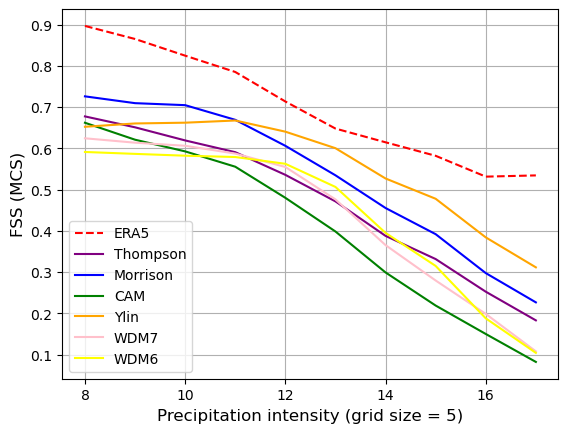

In [17]:
plt.plot(thrsh3, ERA_fssi_mcs, color='r', linestyle='dashed', label='ERA5')
plt.plot(thrsh3, tho_fssi_mcs, color='purple', label='Thompson')
plt.plot(thrsh3, mor_fssi_mcs, color='blue', label='Morrison')
plt.plot(thrsh3, cam_fssi_mcs, color='green', label='CAM')
plt.plot(thrsh3, ylin_fssi_mcs, color='orange', label='Ylin')
plt.plot(thrsh3, wdm7_fssi_mcs, color='pink', label='WDM7')
plt.plot(thrsh3, wdm6_fssi_mcs, color='yellow', label='WDM6')

plt.legend()
plt.grid()
plt.ylabel('FSS (MCS)', fontsize=12)
plt.xlabel('Precipitation intensity (grid size = 5)', fontsize=12)

In [18]:
# Compute FSS for different precipitation intensities
thrsh4 = np.arange(4,18.5,0.5) # to have the intensity size of the neighbourhood
kernel4 = [10]
ERA_fssi_snow = fss_det(smeant_prERAc.values, smeant_prIMERGc.values, thrsh4, kernel4)
tho_fssi_snow = fss_det(smeant_prthoc.values, smeant_prIMERGc.values, thrsh4, kernel4)
mor_fssi_snow = fss_det(smeant_prmorc.values, smeant_prIMERGc.values, thrsh4, kernel4)
cam_fssi_snow = fss_det(smeant_prcamc.values, smeant_prIMERGc.values, thrsh4, kernel4)
ylin_fssi_snow = fss_det(smeant_prylinc.values, smeant_prIMERGc.values, thrsh4, kernel4)
wdm7_fssi_snow = fss_det(smeant_prwdm7c.values, smeant_prIMERGc.values, thrsh4, kernel4)
wdm6_fssi_snow = fss_det(smeant_prwdm6c.values, smeant_prIMERGc.values, thrsh4, kernel4)

Text(0.5, 0, 'Precipitation intensity (grid size = 5)')

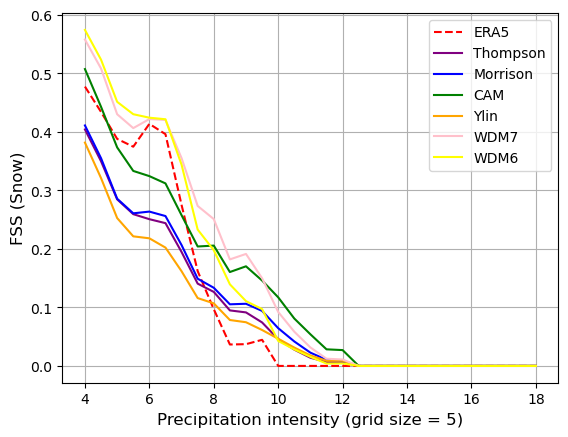

In [19]:
plt.plot(thrsh4, ERA_fssi_snow, color='r', linestyle='dashed', label='ERA5')
plt.plot(thrsh4, tho_fssi_snow, color='purple', label='Thompson')
plt.plot(thrsh4, mor_fssi_snow, color='blue', label='Morrison')
plt.plot(thrsh4, cam_fssi_snow, color='green', label='CAM')
plt.plot(thrsh4, ylin_fssi_snow, color='orange', label='Ylin')
plt.plot(thrsh4, wdm7_fssi_snow, color='pink', label='WDM7')
plt.plot(thrsh4, wdm6_fssi_snow, color='yellow', label='WDM6')

plt.legend()
plt.grid()
plt.ylabel('FSS (Snow)', fontsize=12)
plt.xlabel('Precipitation intensity (grid size = 5)', fontsize=12)

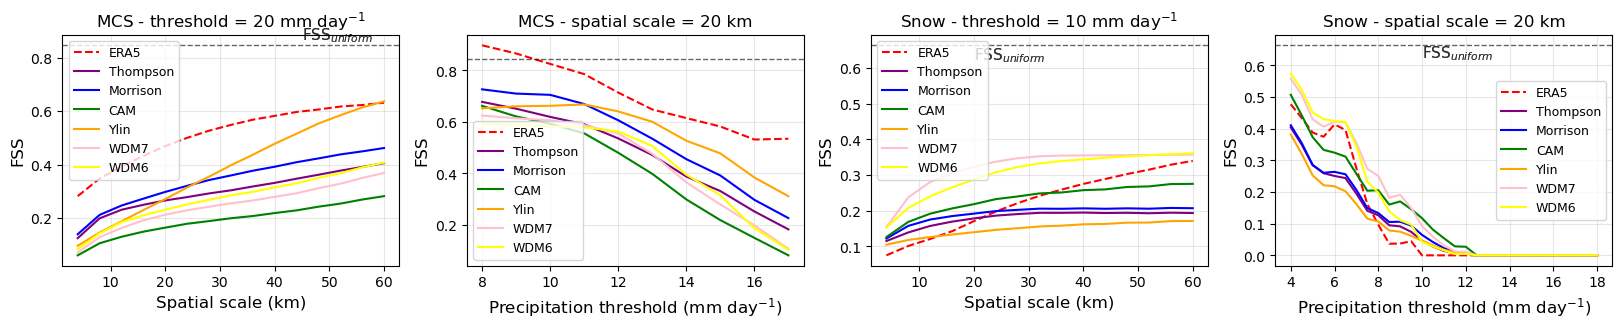

In [20]:
## Paper using 20 km and 20-10 mm/day
FSSu = (FSSu_mcs[0], FSSu_mcs[0], FSSu_snow[0], FSSu_snow[0])

nrows, ncols = 1,4
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20,3))
axs = axs.flatten()

axs[0].plot(kernel1*4, ERA_fssg_mcs.flatten(), color='r', linestyle='dashed', label='ERA5')
axs[0].plot(kernel1*4, tho_fssg_mcs.flatten(), color='purple', label='Thompson')
axs[0].plot(kernel1*4, mor_fssg_mcs.flatten(), color='blue', label='Morrison')
axs[0].plot(kernel1*4, cam_fssg_mcs.flatten(), color='green', label='CAM')
axs[0].plot(kernel1*4, ylin_fssg_mcs.flatten(), color='orange', label='Ylin')
axs[0].plot(kernel1*4, wdm7_fssg_mcs.flatten(), color='pink', label='WDM7')
axs[0].plot(kernel1*4, wdm6_fssg_mcs.flatten(), color='yellow', label='WDM6')
axs[0].legend(fontsize=9)
axs[0].grid(alpha=0.3)
axs[0].set_title(r'MCS - threshold = 20 mm day$^{-1}$', fontsize=12)
axs[0].set_ylabel('FSS', fontsize=12)
#axs[0].set_yticks([0.70,0.75, 0.80,0.85, 0.90,0.95, 1])
axs[0].set_xlabel('Spatial scale (km)', fontsize=12)

axs[1].plot(thrsh3, ERA_fssi_mcs, color='r', linestyle='dashed', label='ERA5')
axs[1].plot(thrsh3, tho_fssi_mcs, color='purple', label='Thompson')
axs[1].plot(thrsh3, mor_fssi_mcs, color='blue', label='Morrison')
axs[1].plot(thrsh3, cam_fssi_mcs, color='green', label='CAM')
axs[1].plot(thrsh3, ylin_fssi_mcs, color='orange', label='Ylin')
axs[1].plot(thrsh3, wdm7_fssi_mcs, color='pink', label='WDM7')
axs[1].plot(thrsh3, wdm6_fssi_mcs, color='yellow', label='WDM6')
axs[1].legend(fontsize=9, loc='lower left')
axs[1].grid(alpha=0.3)
axs[1].set_title('MCS - spatial scale = 20 km', fontsize=12)
axs[1].set_ylabel('FSS', fontsize=12)
#axs[1].set_ylim([0.45,1])
#axs[1].set_yticks([0.45, 0.55, 0.65, 0.75, 0.85, 0.95,])
axs[1].set_xlabel(r'Precipitation threshold (mm day$^{-1}$)', fontsize=12)

axs[2].plot(kernel2*4, ERA_fssg_snow.flatten(), color='r', linestyle='dashed', label='ERA5')
axs[2].plot(kernel2*4, tho_fssg_snow.flatten(), color='purple', label='Thompson')
axs[2].plot(kernel2*4, mor_fssg_snow.flatten(), color='blue', label='Morrison')
axs[2].plot(kernel2*4, cam_fssg_snow.flatten(), color='green', label='CAM')
axs[2].plot(kernel2*4, ylin_fssg_snow.flatten(), color='orange', label='Ylin')
axs[2].plot(kernel2*4, wdm7_fssg_snow.flatten(), color='pink', label='WDM7')
axs[2].plot(kernel2*4, wdm6_fssg_snow.flatten(), color='yellow', label='WDM6')
axs[2].legend(fontsize=9)
axs[2].grid(alpha=0.3)
axs[2].set_title(r'Snow - threshold = 10 mm day$^{-1}$', fontsize=12)
axs[2].set_ylabel('FSS', fontsize=12)
#axs[2].set_yticks([0.75,0.80, 0.85, 0.90, 0.95])
axs[2].set_xlabel('Spatial scale (km)', fontsize=12)

axs[3].plot(thrsh4, ERA_fssi_snow, color='r', linestyle='dashed', label='ERA5')
axs[3].plot(thrsh4, tho_fssi_snow, color='purple', label='Thompson')
axs[3].plot(thrsh4, mor_fssi_snow, color='blue', label='Morrison')
axs[3].plot(thrsh4, cam_fssi_snow, color='green', label='CAM')
axs[3].plot(thrsh4, ylin_fssi_snow, color='orange', label='Ylin')
axs[3].plot(thrsh4, wdm7_fssi_snow, color='pink', label='WDM7')
axs[3].plot(thrsh4, wdm6_fssi_snow, color='yellow', label='WDM6')
axs[3].set_title('Snow - spatial scale = 20 km', fontsize=12)
axs[3].legend(fontsize=9)
axs[3].grid(alpha=0.3)
axs[3].set_ylabel('FSS', fontsize=12)
#axs[3].set_yticks([0.65, 0.70, 0.75, 0.80, 0.85])
axs[3].set_xlabel(r'Precipitation threshold (mm day$^{-1}$)', fontsize=12)

#Add thresholds
for i in range(0, 4):
  axs[i].axhline(y=FSSu[i], color='k', linestyle='dashed', linewidth=1, alpha=0.6)
  axs[0].text(45, FSSu[0]+0.02, r'FSS$_{uniform}$', color='k', alpha=0.35, fontsize=11)
  axs[1].text(20, FSSu[1]+0.02, r'FSS$_{uniform}$', color='k', alpha=0.35, fontsize=11)
  axs[2].text(20, FSSu[2]-0.04, r'FSS$_{uniform}$', color='k', alpha=0.35, fontsize=11)
  axs[3].text(10, FSSu[3]-0.04, r'FSS$_{uniform}$', color='k', alpha=0.35, fontsize=11)

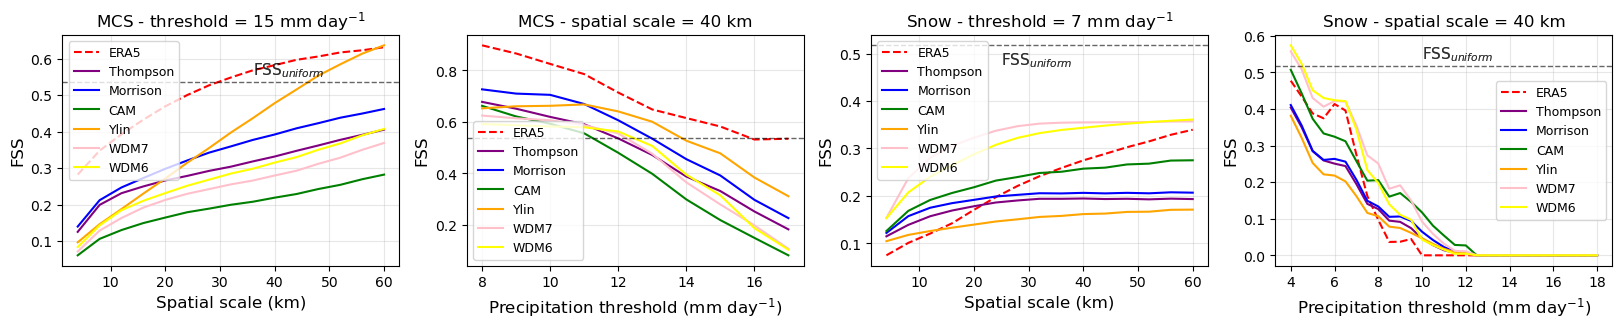

In [21]:
## Paper using 40 km and 15-7 mm/day
FSSu = (FSSu_mcs[2], FSSu_mcs[2], FSSu_snow[2], FSSu_snow[2])

nrows, ncols = 1,4
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20,3))
axs = axs.flatten()

axs[0].plot(kernel1*4, ERA_fssg_mcs.flatten(), color='r', linestyle='dashed', label='ERA5')
axs[0].plot(kernel1*4, tho_fssg_mcs.flatten(), color='purple', label='Thompson')
axs[0].plot(kernel1*4, mor_fssg_mcs.flatten(), color='blue', label='Morrison')
axs[0].plot(kernel1*4, cam_fssg_mcs.flatten(), color='green', label='CAM')
axs[0].plot(kernel1*4, ylin_fssg_mcs.flatten(), color='orange', label='Ylin')
axs[0].plot(kernel1*4, wdm7_fssg_mcs.flatten(), color='pink', label='WDM7')
axs[0].plot(kernel1*4, wdm6_fssg_mcs.flatten(), color='yellow', label='WDM6')
axs[0].legend(fontsize=9)
axs[0].grid(alpha=0.3)
axs[0].set_title(r'MCS - threshold = 15 mm day$^{-1}$', fontsize=12)
axs[0].set_ylabel('FSS', fontsize=12)
#axs[0].set_yticks([0.70,0.75, 0.80,0.85, 0.90,0.95, 1])
axs[0].set_xlabel('Spatial scale (km)', fontsize=12)

axs[1].plot(thrsh3, ERA_fssi_mcs, color='r', linestyle='dashed', label='ERA5')
axs[1].plot(thrsh3, tho_fssi_mcs, color='purple', label='Thompson')
axs[1].plot(thrsh3, mor_fssi_mcs, color='blue', label='Morrison')
axs[1].plot(thrsh3, cam_fssi_mcs, color='green', label='CAM')
axs[1].plot(thrsh3, ylin_fssi_mcs, color='orange', label='Ylin')
axs[1].plot(thrsh3, wdm7_fssi_mcs, color='pink', label='WDM7')
axs[1].plot(thrsh3, wdm6_fssi_mcs, color='yellow', label='WDM6')
axs[1].legend(fontsize=9, loc='lower left')
axs[1].grid(alpha=0.3)
axs[1].set_title('MCS - spatial scale = 40 km', fontsize=12)
axs[1].set_ylabel('FSS', fontsize=12)
#axs[1].set_ylim([0.45,1])
#axs[1].set_yticks([0.45, 0.55, 0.65, 0.75, 0.85, 0.95,])
axs[1].set_xlabel(r'Precipitation threshold (mm day$^{-1}$)', fontsize=12)

axs[2].plot(kernel2*4, ERA_fssg_snow.flatten(), color='r', linestyle='dashed', label='ERA5')
axs[2].plot(kernel2*4, tho_fssg_snow.flatten(), color='purple', label='Thompson')
axs[2].plot(kernel2*4, mor_fssg_snow.flatten(), color='blue', label='Morrison')
axs[2].plot(kernel2*4, cam_fssg_snow.flatten(), color='green', label='CAM')
axs[2].plot(kernel2*4, ylin_fssg_snow.flatten(), color='orange', label='Ylin')
axs[2].plot(kernel2*4, wdm7_fssg_snow.flatten(), color='pink', label='WDM7')
axs[2].plot(kernel2*4, wdm6_fssg_snow.flatten(), color='yellow', label='WDM6')
axs[2].legend(fontsize=9)
axs[2].grid(alpha=0.3)
axs[2].set_title(r'Snow - threshold = 7 mm day$^{-1}$', fontsize=12)
axs[2].set_ylabel('FSS', fontsize=12)
#axs[2].set_yticks([0.75,0.80, 0.85, 0.90, 0.95])
axs[2].set_xlabel('Spatial scale (km)', fontsize=12)

axs[3].plot(thrsh4, ERA_fssi_snow, color='r', linestyle='dashed', label='ERA5')
axs[3].plot(thrsh4, tho_fssi_snow, color='purple', label='Thompson')
axs[3].plot(thrsh4, mor_fssi_snow, color='blue', label='Morrison')
axs[3].plot(thrsh4, cam_fssi_snow, color='green', label='CAM')
axs[3].plot(thrsh4, ylin_fssi_snow, color='orange', label='Ylin')
axs[3].plot(thrsh4, wdm7_fssi_snow, color='pink', label='WDM7')
axs[3].plot(thrsh4, wdm6_fssi_snow, color='yellow', label='WDM6')
axs[3].set_title('Snow - spatial scale = 40 km', fontsize=12)
axs[3].legend(fontsize=9)
axs[3].grid(alpha=0.3)
axs[3].set_ylabel('FSS', fontsize=12)
#axs[3].set_yticks([0.65, 0.70, 0.75, 0.80, 0.85])
axs[3].set_xlabel(r'Precipitation threshold (mm day$^{-1}$)', fontsize=12)

#Add thresholds
for i in range(0, 4):
  axs[i].axhline(y=FSSu[i], color='k', linestyle='dashed', linewidth=1, alpha=0.6)
  axs[0].text(36, FSSu[0]+0.02, r'FSS$_{uniform}$', color='k', alpha=0.35, fontsize=11)
  axs[1].text(22, FSSu[1]+0.02, r'FSS$_{uniform}$', color='k', alpha=0.35, fontsize=11)
  axs[2].text(25, FSSu[2]-0.04, r'FSS$_{uniform}$', color='k', alpha=0.35, fontsize=11)
  axs[3].text(10, FSSu[3]+0.02, r'FSS$_{uniform}$', color='k', alpha=0.35, fontsize=11)

## FSS vs grid scale with different precipitation intensities

In [22]:
# Compute FSS MCS for different neighbourhoods sizes for 5, 10, 15 mm/day
kernel = np.arange(1,18.1,1) # to have the grid size of the neighbourhood
thrsh = [5]
ERA_fssg5_mcs = fss_det(meant_prERAc.values, meant_prIMERGc.values, thrsh, kernel)
GLDAS_fssg5_mcs = fss_det(meant_prGLDASc.values, meant_prIMERGc.values, thrsh, kernel)
APHRO_fssg5_mcs = fss_det(meant_prAPHROc.values, meant_prIMERGc.values, thrsh, kernel)
MSWEP_fssg5_mcs = fss_det(meant_prMSWEPc.values, meant_prIMERGc.values, thrsh, kernel)
tho_fssg5_mcs = fss_det(meant_prthoc.values, meant_prIMERGc.values, thrsh, kernel)
mor_fssg5_mcs = fss_det(meant_prmorc.values, meant_prIMERGc.values, thrsh, kernel)
cam_fssg5_mcs = fss_det(meant_prcamc.values, meant_prIMERGc.values, thrsh, kernel)
ylin_fssg5_mcs = fss_det(meant_prylinc.values, meant_prIMERGc.values, thrsh, kernel)
wdm7_fssg5_mcs = fss_det(meant_prwdm7c.values, meant_prIMERGc.values, thrsh, kernel)
wdm6_fssg5_mcs = fss_det(meant_prwdm6c.values, meant_prIMERGc.values, thrsh, kernel)
#
kernel = np.arange(1,18.1,1) # to have the grid size of the neighbourhood
thrsh = [10]
ERA_fssg10_mcs = fss_det(meant_prERAc.values, meant_prIMERGc.values, thrsh, kernel)
GLDAS_fssg10_mcs = fss_det(meant_prGLDASc.values, meant_prIMERGc.values, thrsh, kernel)
APHRO_fssg10_mcs = fss_det(meant_prAPHROc.values, meant_prIMERGc.values, thrsh, kernel)
MSWEP_fssg10_mcs = fss_det(meant_prMSWEPc.values, meant_prIMERGc.values, thrsh, kernel)
tho_fssg10_mcs = fss_det(meant_prthoc.values, meant_prIMERGc.values, thrsh, kernel)
mor_fssg10_mcs = fss_det(meant_prmorc.values, meant_prIMERGc.values, thrsh, kernel)
cam_fssg10_mcs = fss_det(meant_prcamc.values, meant_prIMERGc.values, thrsh, kernel)
ylin_fssg10_mcs = fss_det(meant_prylinc.values, meant_prIMERGc.values, thrsh, kernel)
wdm7_fssg10_mcs = fss_det(meant_prwdm7c.values, meant_prIMERGc.values, thrsh, kernel)
wdm6_fssg10_mcs = fss_det(meant_prwdm6c.values, meant_prIMERGc.values, thrsh, kernel)
#
kernel = np.arange(1,18.1,1) # to have the grid size of the neighbourhood
thrsh = [15]
ERA_fssg15_mcs = fss_det(meant_prERAc.values, meant_prIMERGc.values, thrsh, kernel)
GLDAS_fssg15_mcs = fss_det(meant_prGLDASc.values, meant_prIMERGc.values, thrsh, kernel)
APHRO_fssg15_mcs = fss_det(meant_prAPHROc.values, meant_prIMERGc.values, thrsh, kernel)
MSWEP_fssg15_mcs = fss_det(meant_prMSWEPc.values, meant_prIMERGc.values, thrsh, kernel)
tho_fssg15_mcs = fss_det(meant_prthoc.values, meant_prIMERGc.values, thrsh, kernel)
mor_fssg15_mcs = fss_det(meant_prmorc.values, meant_prIMERGc.values, thrsh, kernel)
cam_fssg15_mcs = fss_det(meant_prcamc.values, meant_prIMERGc.values, thrsh, kernel)
ylin_fssg15_mcs = fss_det(meant_prylinc.values, meant_prIMERGc.values, thrsh, kernel)
wdm7_fssg15_mcs = fss_det(meant_prwdm7c.values, meant_prIMERGc.values, thrsh, kernel)
wdm6_fssg15_mcs = fss_det(meant_prwdm6c.values, meant_prIMERGc.values, thrsh, kernel)

In [23]:
# Compute FSS Snow for different neighbourhoods sizes for 2, 4, 6 mm/day
skernels = np.arange(1,16.1,1) # to have the grid size of the neighbourhood
sthrsh = [2]
ERA_fssg2_snow = fss_det(smeant_prERAc.values, smeant_prIMERGc.values, sthrsh, skernels)
GLDAS_fssg2_snow = fss_det(smeant_prGLDASc.values, smeant_prIMERGc.values, sthrsh, skernels)
MSWEP_fssg2_snow = fss_det(smeant_prMSWEPc.values, smeant_prIMERGc.values, sthrsh, skernels)
tho_fssg2_snow = fss_det(smeant_prthoc.values, smeant_prIMERGc.values, sthrsh, skernels)
mor_fssg2_snow = fss_det(smeant_prmorc.values, smeant_prIMERGc.values, sthrsh, skernels)
cam_fssg2_snow = fss_det(smeant_prcamc.values, smeant_prIMERGc.values, sthrsh, skernels)
ylin_fssg2_snow = fss_det(smeant_prylinc.values, smeant_prIMERGc.values, sthrsh, skernels)
wdm7_fssg2_snow = fss_det(smeant_prwdm7c.values, smeant_prIMERGc.values, sthrsh, skernels)
wdm6_fssg2_snow = fss_det(smeant_prwdm6c.values, smeant_prIMERGc.values, sthrsh, skernels)
#
skernels = np.arange(1,16.1,1) # to have the grid size of the neighbourhood
sthrsh = [4]
ERA_fssg4_snow = fss_det(smeant_prERAc.values, smeant_prIMERGc.values, sthrsh, skernels)
GLDAS_fssg4_snow = fss_det(smeant_prGLDASc.values, smeant_prIMERGc.values, sthrsh, skernels)
MSWEP_fssg4_snow = fss_det(smeant_prMSWEPc.values, smeant_prIMERGc.values, sthrsh, skernels)
tho_fssg4_snow = fss_det(smeant_prthoc.values, smeant_prIMERGc.values, sthrsh, skernels)
mor_fssg4_snow = fss_det(smeant_prmorc.values, smeant_prIMERGc.values, sthrsh, skernels)
cam_fssg4_snow = fss_det(smeant_prcamc.values, smeant_prIMERGc.values, sthrsh, skernels)
ylin_fssg4_snow = fss_det(smeant_prylinc.values, smeant_prIMERGc.values, sthrsh, skernels)
wdm7_fssg4_snow = fss_det(smeant_prwdm7c.values, smeant_prIMERGc.values, sthrsh, skernels)
wdm6_fssg4_snow = fss_det(smeant_prwdm6c.values, smeant_prIMERGc.values, sthrsh, skernels)
#
skernels = np.arange(1,16.1,1) # to have the grid size of the neighbourhood
sthrsh = [6]
ERA_fssg6_snow = fss_det(smeant_prERAc.values, smeant_prIMERGc.values, sthrsh, skernels)
GLDAS_fssg6_snow = fss_det(smeant_prGLDASc.values, smeant_prIMERGc.values, sthrsh, skernels)
MSWEP_fssg6_snow = fss_det(smeant_prMSWEPc.values, smeant_prIMERGc.values, sthrsh, skernels)
tho_fssg6_snow = fss_det(smeant_prthoc.values, smeant_prIMERGc.values, sthrsh, skernels)
mor_fssg6_snow = fss_det(smeant_prmorc.values, smeant_prIMERGc.values, sthrsh, skernels)
cam_fssg6_snow = fss_det(smeant_prcamc.values, smeant_prIMERGc.values, sthrsh, skernels)
ylin_fssg6_snow = fss_det(smeant_prylinc.values, smeant_prIMERGc.values, sthrsh, skernels)
wdm7_fssg6_snow = fss_det(smeant_prwdm7c.values, smeant_prIMERGc.values, sthrsh, skernels)
wdm6_fssg6_snow = fss_det(smeant_prwdm6c.values, smeant_prIMERGc.values, sthrsh, skernels)

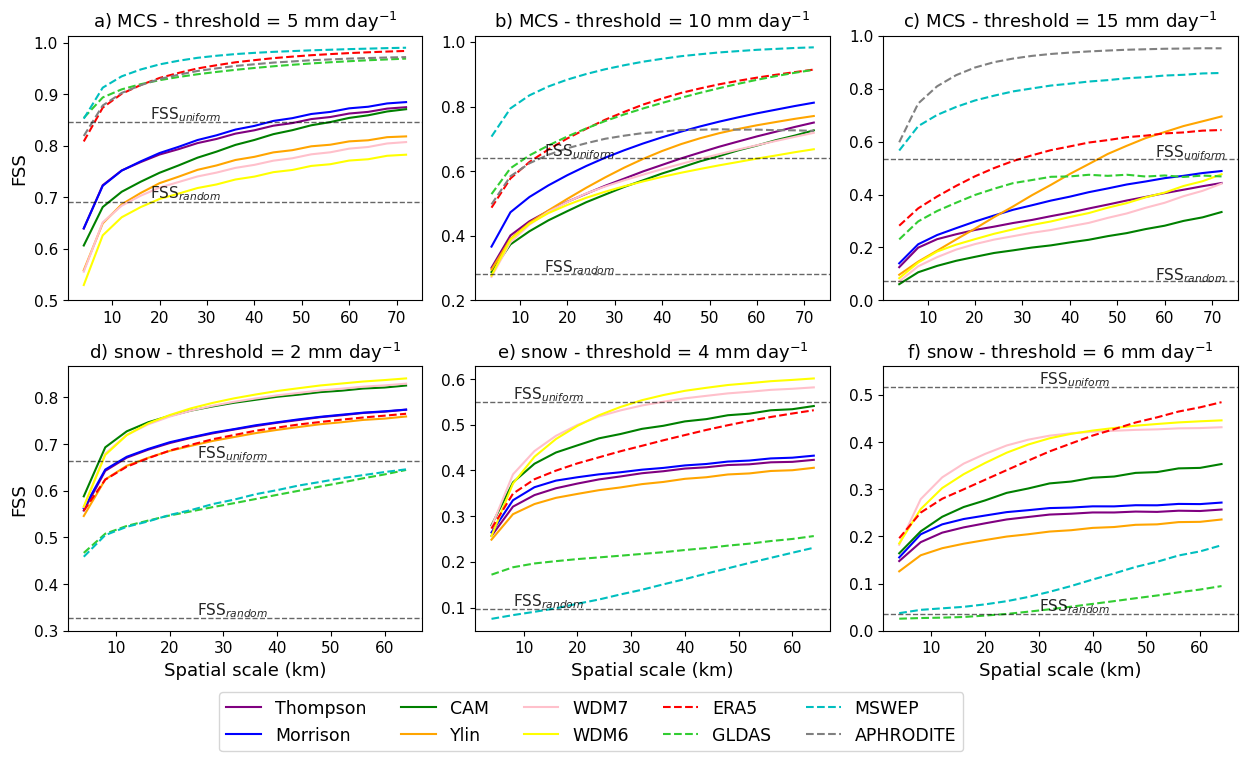

In [35]:
nrows, ncols = 2,3
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(13,7))
axs = axs.flatten()

axs[0].plot(kernel*4, tho_fssg5_mcs.flatten(), color='purple', label='Thompson')
axs[0].plot(kernel*4, mor_fssg5_mcs.flatten(), color='blue', label='Morrison')
axs[0].plot(kernel*4, cam_fssg5_mcs.flatten(), color='green', label='CAM')
axs[0].plot(kernel*4, ylin_fssg5_mcs.flatten(), color='orange', label='Ylin')
axs[0].plot(kernel*4, wdm7_fssg5_mcs.flatten(), color='pink', label='WDM7')
axs[0].plot(kernel*4, wdm6_fssg5_mcs.flatten(), color='yellow', label='WDM6')
axs[0].plot(kernel*4, ERA_fssg5_mcs.flatten(), color='r', linestyle='dashed', label='ERA5')
axs[0].plot(kernel*4, GLDAS_fssg5_mcs.flatten(), color='limegreen', linestyle='dashed', label='GLDAS')
axs[0].plot(kernel*4, MSWEP_fssg5_mcs.flatten(), color='c', linestyle='dashed', label='MSWEP')
axs[0].plot(kernel*4, APHRO_fssg5_mcs.flatten(), color='grey', linestyle='dashed', label='APHRODITE')
axs[0].set_title(r'a) MCS - threshold = 5 mm day$^{-1}$', fontsize=13)
axs[0].set_ylabel('FSS', fontsize=13)
#axs[0].set_xlabel('Spatial scale (km)', fontsize=10)


axs[1].plot(kernel*4, tho_fssg10_mcs.flatten(), color='purple', label='Thompson')
axs[1].plot(kernel*4, mor_fssg10_mcs.flatten(), color='blue', label='Morrison')
axs[1].plot(kernel*4, cam_fssg10_mcs.flatten(), color='green', label='CAM')
axs[1].plot(kernel*4, ylin_fssg10_mcs.flatten(), color='orange', label='Ylin')
axs[1].plot(kernel*4, wdm7_fssg10_mcs.flatten(), color='pink', label='WDM7')
axs[1].plot(kernel*4, wdm6_fssg10_mcs.flatten(), color='yellow', label='WDM6')
axs[1].plot(kernel*4, ERA_fssg10_mcs.flatten(), color='r', linestyle='dashed', label='ERA5')
axs[1].plot(kernel*4, GLDAS_fssg10_mcs.flatten(), color='limegreen', linestyle='dashed', label='GLDAS')
axs[1].plot(kernel*4, MSWEP_fssg10_mcs.flatten(), color='c', linestyle='dashed', label='MSWEP')
axs[1].plot(kernel*4, APHRO_fssg10_mcs.flatten(), color='grey', linestyle='dashed', label='APHRODITE')
#axs[1].legend(fontsize=9)
axs[1].set_title(r'b) MCS - threshold = 10 mm day$^{-1}$', fontsize=13)
#axs[1].set_ylabel('FSS', fontsize=10)
#axs[1].set_xlabel('Spatial scale (km)', fontsize=10)

axs[2].plot(kernel*4, tho_fssg15_mcs.flatten(), color='purple', label='Thompson')
axs[2].plot(kernel*4, mor_fssg15_mcs.flatten(), color='blue', label='Morrison')
axs[2].plot(kernel*4, cam_fssg15_mcs.flatten(), color='green', label='CAM')
axs[2].plot(kernel*4, ylin_fssg15_mcs.flatten(), color='orange', label='Ylin')
axs[2].plot(kernel*4, wdm7_fssg15_mcs.flatten(), color='pink', label='WDM7')
axs[2].plot(kernel*4, wdm6_fssg15_mcs.flatten(), color='yellow', label='WDM6')
axs[2].plot(kernel*4, ERA_fssg15_mcs.flatten(), color='r', linestyle='dashed', label='ERA5')
axs[2].plot(kernel*4, GLDAS_fssg15_mcs.flatten(), color='limegreen', linestyle='dashed', label='GLDAS')
axs[2].plot(kernel*4, MSWEP_fssg15_mcs.flatten(), color='c', linestyle='dashed', label='MSWEP')
axs[2].plot(kernel*4, APHRO_fssg15_mcs.flatten(), color='grey', linestyle='dashed', label='APHRODITE')
#axs[2].legend(fontsize=9)
axs[2].set_title(r'c) MCS - threshold = 15 mm day$^{-1}$', fontsize=13)
#axs[2].set_ylabel('FSS', fontsize=10)
#axs[2].set_xlabel('Spatial scale (km)', fontsize=10)

axs[3].plot(skernels*4, tho_fssg2_snow.flatten(), color='purple', label='Thompson')
axs[3].plot(skernels*4, mor_fssg2_snow.flatten(), color='blue', label='Morrison')
axs[3].plot(skernels*4, cam_fssg2_snow.flatten(), color='green', label='CAM')
axs[3].plot(skernels*4, ylin_fssg2_snow.flatten(), color='orange', label='Ylin')
axs[3].plot(skernels*4, wdm7_fssg2_snow.flatten(), color='pink', label='WDM7')
axs[3].plot(skernels*4, wdm6_fssg2_snow.flatten(), color='yellow', label='WDM6')
axs[3].plot(skernels*4, ERA_fssg2_snow.flatten(), color='r', linestyle='dashed', label='ERA5')
axs[3].plot(skernels*4, GLDAS_fssg2_snow.flatten(), color='limegreen', linestyle='dashed', label='GLDAS')
axs[3].plot(skernels*4, MSWEP_fssg2_snow.flatten(), color='c', linestyle='dashed', label='MSWEP')
#axs[3].legend(fontsize=9)
axs[3].set_title(r'd) snow - threshold = 2 mm day$^{-1}$', fontsize=13)
axs[3].set_ylabel('FSS', fontsize=13)
axs[3].set_xlabel('Spatial scale (km)', fontsize=13)


axs[4].plot(skernels*4, tho_fssg4_snow.flatten(), color='purple', label='Thompson')
axs[4].plot(skernels*4, mor_fssg4_snow.flatten(), color='blue', label='Morrison')
axs[4].plot(skernels*4, cam_fssg4_snow.flatten(), color='green', label='CAM')
axs[4].plot(skernels*4, ylin_fssg4_snow.flatten(), color='orange', label='Ylin')
axs[4].plot(skernels*4, wdm7_fssg4_snow.flatten(), color='pink', label='WDM7')
axs[4].plot(skernels*4, wdm6_fssg4_snow.flatten(), color='yellow', label='WDM6')
axs[4].plot(skernels*4, ERA_fssg4_snow.flatten(), color='r', linestyle='dashed', label='ERA5')
axs[4].plot(skernels*4, GLDAS_fssg4_snow.flatten(), color='limegreen', linestyle='dashed', label='GLDAS')
axs[4].plot(skernels*4, MSWEP_fssg4_snow.flatten(), color='c', linestyle='dashed', label='MSWEP')
#axs[4].legend(fontsize=9)
axs[4].set_title(r'e) snow - threshold = 4 mm day$^{-1}$', fontsize=13)
#axs[4].set_ylabel('FSS', fontsize=10)
axs[4].set_xlabel('Spatial scale (km)', fontsize=13)

axs[5].plot(skernels*4, tho_fssg6_snow.flatten(), color='purple', label='Thompson')
axs[5].plot(skernels*4, mor_fssg6_snow.flatten(), color='blue', label='Morrison')
axs[5].plot(skernels*4, cam_fssg6_snow.flatten(), color='green', label='CAM')
axs[5].plot(skernels*4, ylin_fssg6_snow.flatten(), color='orange', label='Ylin')
axs[5].plot(skernels*4, wdm7_fssg6_snow.flatten(), color='pink', label='WDM7')
axs[5].plot(skernels*4, wdm6_fssg6_snow.flatten(), color='yellow', label='WDM6')
axs[5].plot(skernels*4, ERA_fssg6_snow.flatten(), color='r', linestyle='dashed', label='ERA5')
axs[5].plot(skernels*4, GLDAS_fssg6_snow.flatten(), color='limegreen', linestyle='dashed', label='GLDAS')
axs[5].plot(skernels*4, MSWEP_fssg6_snow.flatten(), color='c', linestyle='dashed', label='MSWEP')
axs[5].set_title(r'f) snow - threshold = 6 mm day$^{-1}$', fontsize=13)
axs[5].set_ylim([0.01,0.56])
axs[5].set_xlabel('Spatial scale (km)', fontsize=13)

#Add thresholds
#for i in range(0, 3):
axs[0].axhline(y=FSSu_mcs[0], color='k', linestyle='dashed', linewidth=1, alpha=0.6)
axs[1].axhline(y=FSSu_mcs[1], color='k', linestyle='dashed', linewidth=1, alpha=0.6)
axs[2].axhline(y=FSSu_mcs[2], color='k', linestyle='dashed', linewidth=1, alpha=0.6)
axs[0].axhline(y=FSSr_mcs[0], color='k', linestyle='dashed', linewidth=1, alpha=0.6)
axs[1].axhline(y=FSSr_mcs[1], color='k', linestyle='dashed', linewidth=1, alpha=0.6)
axs[2].axhline(y=FSSr_mcs[2], color='k', linestyle='dashed', linewidth=1, alpha=0.6)
axs[0].text(18, FSSu_mcs[0]+0.007, r'FSS$_{uniform}$', color='k', alpha=0.85, fontsize=11)
axs[1].text(15, FSSu_mcs[1]+0.008, r'FSS$_{uniform}$', color='k', alpha=0.85, fontsize=11)
axs[2].text(58, FSSu_mcs[2]+0.008, r'FSS$_{uniform}$', color='k', alpha=0.85, fontsize=11)
axs[0].text(18, FSSr_mcs[0]+0.007, r'FSS$_{random}$', color='k', alpha=0.85, fontsize=11)
axs[1].text(15, FSSr_mcs[1]+0.008, r'FSS$_{random}$', color='k', alpha=0.85, fontsize=11)
axs[2].text(58, FSSr_mcs[2]+0.008, r'FSS$_{random}$', color='k', alpha=0.85, fontsize=11)

axs[3].axhline(y=FSSu_snow[0], color='k', linestyle='dashed', linewidth=1, alpha=0.6)
axs[4].axhline(y=FSSu_snow[1], color='k', linestyle='dashed', linewidth=1, alpha=0.6)
axs[5].axhline(y=FSSu_snow[2], color='k', linestyle='dashed', linewidth=1, alpha=0.6)
axs[3].axhline(y=FSSr_snow[0], color='k', linestyle='dashed', linewidth=1, alpha=0.6)
axs[4].axhline(y=FSSr_snow[1], color='k', linestyle='dashed', linewidth=1, alpha=0.6)
axs[5].axhline(y=FSSr_snow[2], color='k', linestyle='dashed', linewidth=1, alpha=0.6)
axs[3].text(25, FSSu_snow[0]+0.007, r'FSS$_{uniform}$', color='k', alpha=0.85, fontsize=11)
axs[4].text(8, FSSu_snow[1]+0.007, r'FSS$_{uniform}$', color='k', alpha=0.85, fontsize=11)
axs[5].text(30, FSSu_snow[2]+0.007, r'FSS$_{uniform}$', color='k', alpha=0.85, fontsize=11)
axs[3].text(25, FSSr_snow[0]+0.007, r'FSS$_{random}$', color='k', alpha=0.85, fontsize=11)
axs[4].text(8, FSSr_snow[1]+0.007, r'FSS$_{random}$', color='k', alpha=0.85, fontsize=11)
axs[5].text(30, FSSr_snow[2]+0.007, r'FSS$_{random}$', color='k', alpha=0.85, fontsize=11)

for i in range(0,6):
    axs[i].tick_params(axis='y', labelsize=11)
    axs[i].tick_params(axis='x', labelsize=11)

axs[0].set_xticks([10, 20, 30, 40, 50, 60, 70])
axs[1].set_xticks([10, 20, 30, 40, 50, 60, 70])
axs[2].set_xticks([10, 20, 30, 40, 50, 60, 70])

axs[0].set_yticks([0.5,0.6,0.7,0.8,0.9,1.0])
axs[1].set_yticks([0.2,0.4, 0.6, 0.8, 1.0])
axs[2].set_yticks([0,0.2, 0.4, 0.6, 0.8, 1.0])
axs[3].set_yticks([0.3,0.4,0.5,0.6,0.7,0.8])
axs[5].set_yticks([0,0.1,0.2,0.3,0.4,0.5])


fig.subplots_adjust(bottom=0.1, top=0.95, left=0.05, right=0.95, wspace=0.15, hspace=0.25)
axs[0].legend(ncol=5, bbox_to_anchor=(2.55, -1.45), fontsize=12.5)


# Save the plot as a hd file
plt.savefig('/media/irene/Elements/Laptop_dec2023/Thesis_data/images_submission/FSS.png', dpi=400, bbox_inches='tight')